An overview EDA(Exploratory Data Analysis) for the project: Learning Equality - Curriculum Recommendations -  A kaggle featured competetion.

# I. Set up libararies and data

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display, Markdown

Import the given data.

In [51]:
#read input from kaggle platform in csv
content_df = pd.read_csv("/kaggle/input/learning-equality-curriculum-recommendations/content.csv")
topics_df = pd.read_csv("/kaggle/input/learning-equality-curriculum-recommendations/topics.csv")
correlations_df = pd.read_csv("/kaggle/input/learning-equality-curriculum-recommendations/correlations.csv")

# II. Overall and visualization

## CONTENT

content.csv - Contains a row for each content item in the dataset. Note that the hidden dataset used for scoring contains additional content items not in the public version. These additional content items are only correlated to topics in the test set. Some content items may not be correlated with any topic.<br/>
- id - A unique identifier for this content item.<br/>
- title - Title text for this content item.<br/>
- description - Description text. May be empty.<br/>
- language - Language code representing the language of this content item.<br/>
- kind - Describes what format of content this item represents, as one of:<br/>
    - document (text is extracted from a PDF or EPUB file)<br/>
    - video (text is extracted from the subtitle file, if available)<br/>
    - exercise (text is extracted from questions/answers)<br/>
    - audio (no text)<br/>
    - html5 (text is extracted from HTML source)<br/>
- text - Extracted text content, if available and if licensing permitted (around half of content items have text content).<br/>
- copyright_holder - If text was extracted from the content, indicates the owner of the copyright for that content. Blank for all test set items.<br/>
- license - If text was extracted from the content, the license under which that content was made available. Blank for all test set items.<br/>

In [5]:
content_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 154047 entries, 0 to 154046
Data columns (total 8 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   id                154047 non-null  object
 1   title             154038 non-null  object
 2   description       89456 non-null   object
 3   kind              154047 non-null  object
 4   text              74035 non-null   object
 5   language          154047 non-null  object
 6   copyright_holder  71821 non-null   object
 7   license           74035 non-null   object
dtypes: object(8)
memory usage: 9.4+ MB


In [45]:
content_df.sample(frac = 1).head(3)

,index,id,title,description,kind,text,language,copyright_holder,license
125002,125002,c_cfae70013066,Mathematics Grade 11 Students E-Textbook,NaN,document,MATHEMATICS\nSTUDENT TEXTBOOK\nGRADE11\nGRADE1...,en,FDRE Ministry of Education,CC BY
134384,134384,c_df1e8cd6535a,LUGHA TATU!! Miraba Mingapi?!!,NaN,video,NaN,swa,NaN,NaN
79815,79815,c_84b156de8163,20.3: The while Statement,NaN,html5,Computers are often used to automate repetitiv...,en,CSU and Merlot,CC BY-NC-SA


Most of the content has title , but only half of them has text and maybe description. For each content, the title is mostly guaranteed but some maybe missing description, some maybe missing text or both.<br/>
As we can see, the most important columns that represent a content are: title, description, text. Maybe language or kind can contribute to the model, but lets view only 3 mains attributes.

In [11]:
import random
idx = random.randint(0,len(content_df)-1)
print(f"id: {content_df.index[idx]}\n"
      f"language: {content_df['language'].iloc[idx]}\n"
      f"title: {content_df['title'].iloc[idx]}\n"
      f"description: {content_df['description'].iloc[idx]}\n"
      f"text: {content_df['text'].iloc[idx]}\n" ## we will only see a part of text since it could be very long
)

id: 98999
language: bn
title: অসমতার কথার সমস্যা
description: বাস্তব পরিস্থিতিতে অসমতার মডেল লিখতে শিখ।
text: nan



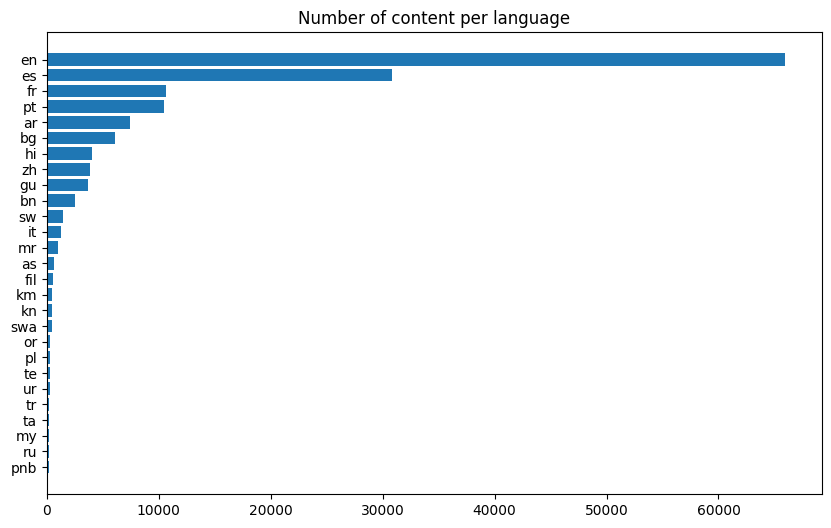

In [12]:
# visualize language distribution accross the content
language_counts = content_df["language"].value_counts(ascending = True)
plt.figure(figsize=(10, 6))
plt.barh(language_counts.index, language_counts.values)
plt.title("Number of content per language")
plt.show()

The most language is English, follow by Espanol and then France and Portuguese

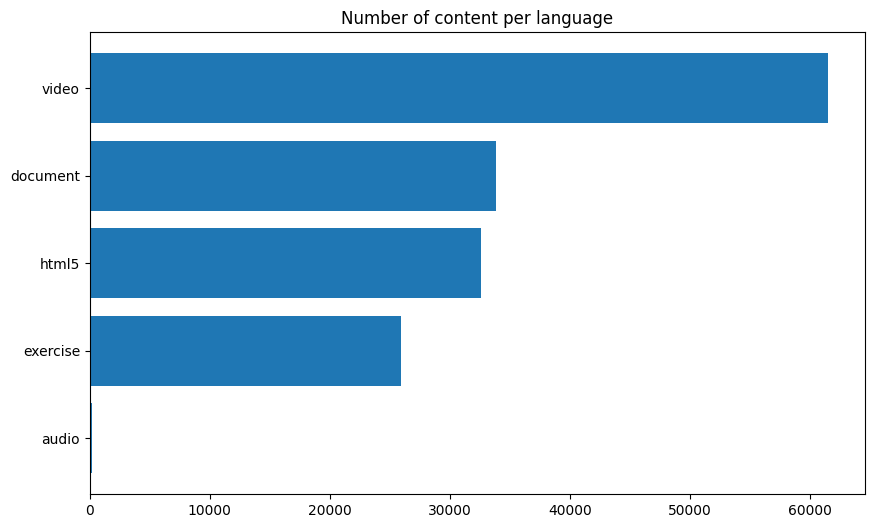

In [13]:
#visualize type of kinds for content
kind_counts = content_df["kind"].value_counts(ascending = True)
plt.figure(figsize=(10, 6))
plt.barh(kind_counts.index, kind_counts.values)
plt.title("Number of content per language")
plt.show()

The most popular type of content is video, audio has only few samples.

## TOPIC 

topics.csv - Contains a row for each topic in the dataset. These topics are organized into "channels", with each channel containing a single "topic tree" (which can be traversed through the "parent" reference). Note that the hidden dataset used for scoring contains additional topics not in the public version. You should only submit predictions for those topics listed in sample_submission.csv.<br/>
- id - A unique identifier for this topic.<br/>
- title - Title text for this topic.<br/>
- description - Description text (may be empty)<br/>
- channel - The channel (that is, topic tree) this topic is part of.
- category - Describes the origin of the topic.
    - source - Structure was given by original content creator (e.g. the topic tree as imported from Khan Academy). There are no topics in the test set with this category.<br/>
    - aligned - Structure is from a national curriculum or other target taxonomy, with content aligned from multiple sources.<br/>
    - supplemental - This is a channel that has to some extent been aligned, but without the same level of granularity or fidelity as an aligned channel.<br/>
- language - Language code for the topic. May not always match apparent language of its title or description, but will always match the language of any associated content items.
- parent - The id of the topic that contains this topic, if any. This field if empty if the topic is the root node for its channel.
- level - The depth of this topic within its topic tree. Level 0 means it is a root node (and hence its title is the title of the channel).
has_content - Whether there are content items correlated with this topic. Most content is correlated with leaf topics, but some non-leaf topics also have content correlations.

In [14]:
topics_df.info()
topics_df.sample(frac = 1).head(3)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 76972 entries, 0 to 76971
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   id           76972 non-null  object
 1   title        76970 non-null  object
 2   description  34953 non-null  object
 3   channel      76972 non-null  object
 4   category     76972 non-null  object
 5   level        76972 non-null  int64 
 6   language     76972 non-null  object
 7   parent       76801 non-null  object
 8   has_content  76972 non-null  bool  
dtypes: bool(1), int64(1), object(7)
memory usage: 4.8+ MB


,id,title,description,channel,category,level,language,parent,has_content
26624,t_5937071b7a2b,Geometría,"En este eje, se espera que los estudiantes apr...",998df9,supplemental,2,es,t_218f7452254b,False
46017,t_9a1d3cfde7df,Numeri irrazionali,Scopri i numeri irrazionali e come riconoscerli.,60b280,source,3,it,t_0bf5bfa6b3cc,False
54951,t_b7d7f4052ada,Mafumbo ndani ya 100,Jifunze jinsi ya kukokotoa kujumlisha na kutoa...,0c929f,source,4,sw,t_33e84c486449,True


In [15]:
len(topics_df[topics_df['has_content'] == True])

61517

Not all topics have content, keep that in mind since we will only use topic that has content as the input for our model.

Lets view a random topic.

In [60]:
idx = random.randint(0,len(topics_df)-1)
print(f"id: {topics_df.index[idx]}\n"
      f"language: {topics_df['language'].iloc[idx]}\n"
      f"title: {topics_df['title'].iloc[idx]}\n"
      f"description: {topics_df['description'].iloc[idx]}\n"
)

id: 71980
language: fr
title: Les droits des enfants et les obstacles
description: Education Sociale et Financière pour Enfants



## CORRELATION 

This table show the correlation between a topic_id and a content_id, which we can use to create a tree-like architectur for each topic

In [17]:
correlations_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 61517 entries, 0 to 61516
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   topic_id     61517 non-null  object
 1   content_ids  61517 non-null  object
dtypes: object(2)
memory usage: 961.3+ KB


In [18]:
correlations_df.sample(frac = 1).head(10)

,topic_id,content_ids
11183,t_2ef062158161,c_2f49a66cc709
44141,t_b8b508a123d6,c_5a61937e9e2a c_8c3bc6f24d55
55501,t_e73ebbfafd9c,c_0c3fc2d3617f c_83231a0fb0b1 c_a982872901e7 c...
29997,t_7d7903993ef8,c_09d7e36bde31 c_25fbcd4f89a5 c_443226887d37 c...
48117,t_c8e57fbb822a,c_ba9802e3c454
42199,t_b0c27c7fdc07,c_045f37ac6f4b c_160e091cc3a5 c_1cb9fca92bc8 c...
61469,t_ffc56ccf41fd,c_02159e3579bb c_0615d5339c03 c_0b9017368c43 c...
10329,t_2b73e92b7ef0,c_bcde77ed9b0a c_f0cbaecc4000 c_faad335106b6
14483,t_3cea2c3bfbb9,c_21ba90eaa4f7 c_4a110ba2a0f9 c_71b2f6f5ba7c c...
23173,t_6142e3a4ce92,c_055a2ce2f7b2 c_249625b389e0 c_2a1ab3b27e2f c...


Lets split the content so that each content is assigned to 1 topic.

In [23]:
correlations_df["content_ids"] = correlations_df["content_ids"].str.split(" ")
correlations_df = correlations_df.explode("content_ids").reset_index(drop=True)
correlations_df.sample(frac = 1).head(10)

,topic_id,content_ids
113590,t_68d6418b7da1,c_6727e257413e
261237,t_efdd77976e01,c_1e80ce47c545
115606,t_6adce65200c0,c_866c24b9112d
69486,t_4061e953c4e4,c_ab183950d84b
37198,t_2262c92403a4,c_23f258edf051
33830,t_1f4eba67c02a,c_2aa6b5877cd8
275478,t_fc2c93ada19f,c_8eb9b73d76d1
67873,t_3eeb1b058c6c,c_062071de7021
225379,t_cf3a8f9f2329,c_1e256d94701f
162942,t_96f651f63a91,c_c90e489b6dda


In [24]:
filtered_cr = correlations_df[correlations_df["topic_id"].isin(
    topics_df["id"][topics_df["language"] == "en"])]

In [29]:
content_per_topic = filtered_cr["topic_id"].value_counts().values

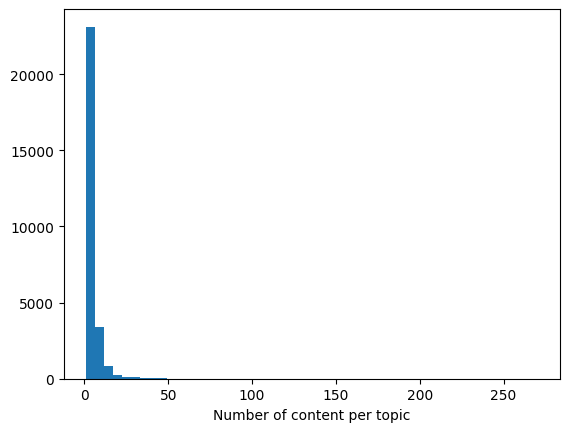

In [30]:
plt.hist(content_per_topic, bins = 50)
plt.xlabel("Number of content per topic")
plt.show()

In [33]:
print("Mean number of contents per topic: ", np.mean(content_per_topic))
print("Max number of contents per topic: ", np.max(content_per_topic))
print("Min number of contents per topic: ", np.min(content_per_topic))

for k in range(50, 100, 10):
    print(f"{k}% value of number of contents per topic: ", np.percentile(content_per_topic, k))

Mean number of contents per topic:  4.553416746871992
Max number of contents per topic:  270
Min number of contents per topic:  1
50% value of number of contents per topic:  3.0
60% value of number of contents per topic:  3.0
70% value of number of contents per topic:  4.0
80% value of number of contents per topic:  6.0
90% value of number of contents per topic:  9.0


A topic can have up to 270 content while the minimum value is 1. But the number tends to be around 1-10.

# III. Tree Visualization

This part help understanding the construction of the data. In general, a subtopic as Math can be a part of a bigger topic such as Calculus and furthermore. We will see the details below.

In [47]:
# fill missing values and set the id to be index for better processing
content_df = pd.read_csv("/kaggle/input/learning-equality-curriculum-recommendations/content.csv", index_col = 0).fillna("")
topics_df = pd.read_csv("/kaggle/input/learning-equality-curriculum-recommendations/topics.csv", index_col = 0).fillna({"title": "", "description": ""})
correlations_df = pd.read_csv("/kaggle/input/learning-equality-curriculum-recommendations/correlations.csv", index_col = 0)

## 3.1 Helper functions

Define 2 classes to help viewing the full tree with the following architecture:<br/> 
Ancestors -> Parents -> Self, Siblings -> Children

In [48]:
# define some helper functions and classes to aid with data traversal

def print_markdown(md):
    display(Markdown(md))

class Topic:
    def __init__(self, topic_id):
        self.id = topic_id

    @property
    def parent(self):
        parent_id = topics_df.loc[self.id].parent
        if pd.isna(parent_id):
            return None
        else:
            return Topic(parent_id)

    @property
    def ancestors(self):
        ancestors = []
        parent = self.parent
        while parent is not None:
            ancestors.append(parent)
            parent = parent.parent
        return ancestors

    @property
    def siblings(self):
        if not self.parent:
            return []
        else:
            return [topic for topic in self.parent.children if topic != self]

    @property
    def content(self):
        if self.id in correlations_df.index:
            return [ContentItem(content_id) for content_id in correlations_df.loc[self.id].content_ids.split()]
        else:
            return tuple([]) if self.has_content else []

    def get_breadcrumbs(self, separator=" --> ", include_self=True, include_root=True):
        ancestors = self.ancestors
        if include_self:
            ancestors = [self] + ancestors
        if not include_root:
            ancestors = ancestors[:-1]
        return separator.join(reversed([a.title for a in ancestors]))

    @property
    def children(self):
        return [Topic(child_id) for child_id in topics_df[topics_df.parent == self.id].index]

    def subtree_markdown(self, depth=0):
        indent = "  " * depth
        markdown = f"{indent}- [Topic] {self.title}\n"
    
        for child in self.children:
            markdown += child.subtree_markdown(depth=depth + 1)
    
        for content in self.content:
            content_indent = "  " * (depth + 1)
            content_kind = content.kind.title() if hasattr(content, "kind") else "Content"
            markdown += f"{content_indent}- [Content: {content_kind}] {content.title}\n"

        return markdown


    def __eq__(self, other):
        if not isinstance(other, Topic):
            return False
        return self.id == other.id

    def __getattr__(self, name):
        return topics_df.loc[self.id][name]

    def __str__(self):
        return self.title
    
    def __repr__(self):
        return f"<Topic(id={self.id}, title=\"{self.title}\")>"


class ContentItem:
    def __init__(self, content_id):
        self.id = content_id

    @property
    def topics(self):
        return [Topic(topic_id) for topic_id in topics_df.loc[correlations_df[correlations_df.content_ids.str.contains(self.id)].index].index]

    def __getattr__(self, name):
        return content_df.loc[self.id][name]

    def __str__(self):
        return self.title
    
    def __repr__(self):
        return f"<ContentItem(id={self.id}, title=\"{self.title}\")>"

    def __eq__(self, other):
        if not isinstance(other, ContentItem):
            return False
        return self.id == other.id

    def get_all_breadcrumbs(self, separator=" >> ", include_root=True):
        breadcrumbs = []
        for topic in self.topics:
            new_breadcrumb = topic.get_breadcrumbs(separator=separator, include_root=include_root)
            if new_breadcrumb:
                new_breadcrumb = new_breadcrumb + separator + self.title
            else:
                new_breadcrumb = self.title
            breadcrumbs.append(new_breadcrumb)
        return breadcrumbs

## 3.2 View some random tree

Lets view the construction of a random topic.

In [49]:
idx = random.randint(0, len(topics_df)-1)
t = Topic(topics_df.index[idx])
print_markdown("\n#### Title:")
print(t.title)
print()
print_markdown("#### Description:")
print(t.description)
print()
print_markdown("#### Breadcrumbs:")
print(t.get_breadcrumbs())
print()
print_markdown("#### Parent:")
print(t.parent)
print()
print_markdown("#### Siblings:")
print(t.siblings)
print()
print_markdown("#### Children:")
print(t.children)
print()
print_markdown("#### Content:")
print(t.content)
if t.content:
    print_markdown("#### All breadcrumbs for first content item:")
    print_markdown("- " + "\n- ".join(t.content[0].get_all_breadcrumbs()))


#### Title:

Subtraction of Polynomials



#### Description:

#### Breadcrumbs:

CBSE --> CBSE Content - Final --> CBSE 7 --> Maths --> Algebraic Expressions --> Subtraction of Polynomials



#### Parent:

Algebraic Expressions



#### Siblings:

[<Topic(id=t_e8a5d13344cf, title="Introduction to Variables and Algebraic Expressions")>]



#### Children:

[]



#### Content:

[<ContentItem(id=c_69b55e3ddfea, title="Subtraction of Polynomials")>]


#### All breadcrumbs for first content item:

- Maths G3 to G10 >> Maths >> G9 >> 3. Polynomials >> Operations on polynomials >> Videos >> Subtraction of Polynomials
- CBSE >> CBSE Content - Final >> CBSE 8 >> Maths >> Algebraic Expressions and Identities >> Subtraction of Polynomials >> Subtraction of Polynomials
- Maths G3 to G10 >> Maths >> G7 >> 8. Algebraic expressions and operations on them >> Subtraction of algebraic expressions >> Videos >> Subtraction of Polynomials
- CBSE >> CBSE Content - Final >> CBSE 7 >> Maths >> Algebraic Expressions >> Subtraction of Polynomials >> Subtraction of Polynomials

Now only view the topic subtree for simplicity.

In [50]:
idx = random.randint(0, len(topics_df)-1)
t = Topic(topics_df[topics_df.has_content].index[idx])
# (we truncate the output to 35 lines here to avoid overwhelming the notebook)
print_markdown("\n".join(t.subtree_markdown().split("\n")[:35]))

- [Topic] भिन्नों के साथ आयतन 
  - [Content: Video] एक आयताकार प्रिज्म का आयतन: शब्द समस्या 
  - [Content: Exercise] Volume with cubes with fraction lengths
  - [Content: Exercise] Volume by multiplying area of base times height
  - [Content: Exercise] भिन्नों के साथ आयतन 
  - [Content: Video] एक आयताकार प्रिज्म का आयतन: भिन्नात्मक आयाम 
  - [Content: Exercise] आयतन शब्द समस्याएँ: भिन्न और दशमलव
